<h1>Adult Census Income Category Prediction</h1>

<h2>Initial Set-Up</h2>

In [1]:
import numpy as np  
import pandas as pd  
# libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score

# data scaling
from sklearn.preprocessing import scale, MinMaxScaler
# test data
from sklearn.metrics import accuracy_score

# models
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb

# libraries for ANN
 
from tensorflow import keras
import tensorflow as tf
from scikeras.wrappers import KerasClassifier, KerasRegressor

In [2]:
df = pd.read_csv('adult.csv', sep=",")
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [3]:
df.shape

(32561, 15)

Above output shows our dataset has 32561 rows and 15 columns(attributes) 

<h2>Target variable</h2>

* Income is the target variable

In [4]:
df['income'].unique() # show unique values

array(['<=50K', '>50K'], dtype=object)

* Here we replace with 1 for all entries which have income >50k and with 0 which have income <=50k to count them

In [5]:
df['income'].replace(['<=50K','>50K'],[0,1], inplace=True) # replace with 0 and 1
df['income'].value_counts() # show number of samples for each value

0    24720
1     7841
Name: income, dtype: int64

In [6]:
# we can see the percentage of people that have >50k:
np.mean(df['income'])

0.2408095574460244

In [7]:
df['workclass'].value_counts() 

Private             22696
Self-emp-not-inc     2541
Local-gov            2093
?                    1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: workclass, dtype: int64

* Above output displays the number of missing values in  workclass(As we see there are 1836 missing values) and also other attributes with respective number of values

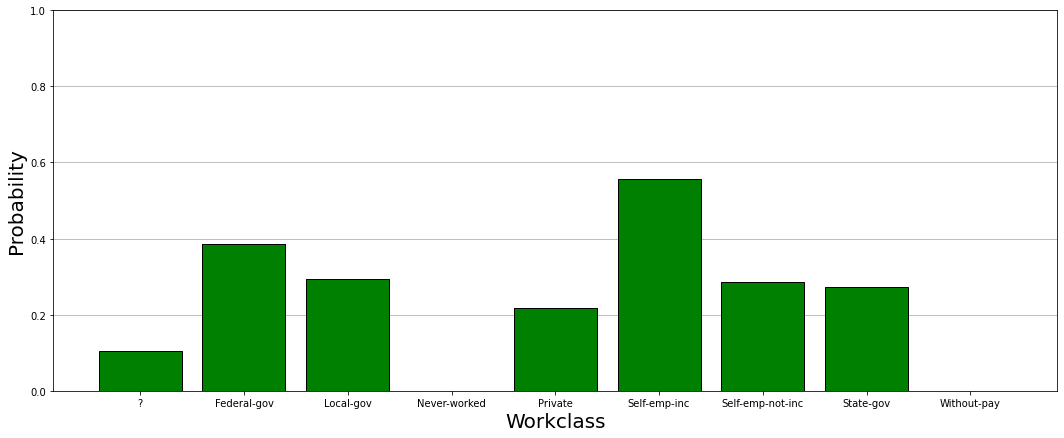

In [8]:
# probability of belonging to the group with the highest income
workclass_income = df.groupby('workclass')['income'].mean() # there is correlation as expected

plt.rcParams['axes.axisbelow'] = True # grid behind graphs bars
plt.figure(figsize=(18, 7))
plt.ylim(0,1) # values from 0 to 1 as there are probabilities
plt.bar(workclass_income.index.astype(str), workclass_income,
       color = 'green' , edgecolor='black' )
plt.ylabel('Probability', size=20)
plt.xlabel('Workclass', size=20)
plt.grid(axis='y')

* As we can see in the above diagram self-employment peeps have higher probability of getting salary >50k

In [9]:
df['education'].unique()     #there are no null valuse as we can see below

array(['HS-grad', 'Some-college', '7th-8th', '10th', 'Doctorate',
       'Prof-school', 'Bachelors', 'Masters', '11th', 'Assoc-acdm',
       'Assoc-voc', '1st-4th', '5th-6th', '12th', '9th', 'Preschool'],
      dtype=object)

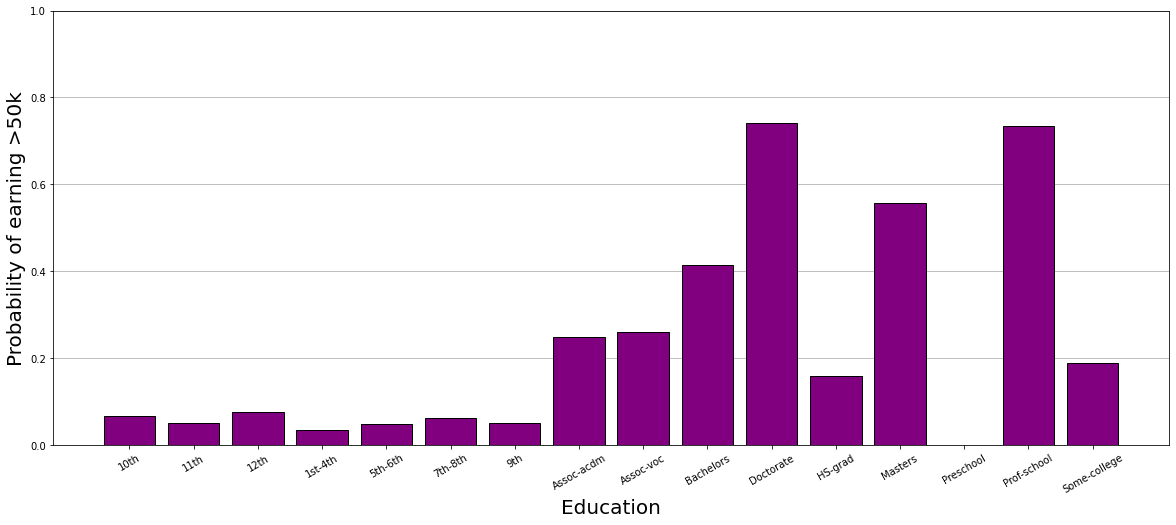

In [10]:
# probability of belonging to the group with the highest income
education_income = df.groupby('education')['income'].mean()

plt.figure(figsize=(20, 8))
plt.ylim(0,1)
plt.xticks(rotation=30) # rotate axis text
plt.bar(education_income.index.astype(str), education_income,
       color = 'purple', edgecolor='black' )
plt.ylabel('Probability of earning >50k', size=20)
plt.xlabel('Education', size=20)
plt.grid(axis='y')

* From the above graph we can infer that doctorate and prof-school educated people have more probability of getting salary of >50k

In [11]:
 df['marital.status'].unique() 

array(['Widowed', 'Divorced', 'Separated', 'Never-married',
       'Married-civ-spouse', 'Married-spouse-absent', 'Married-AF-spouse'],
      dtype=object)

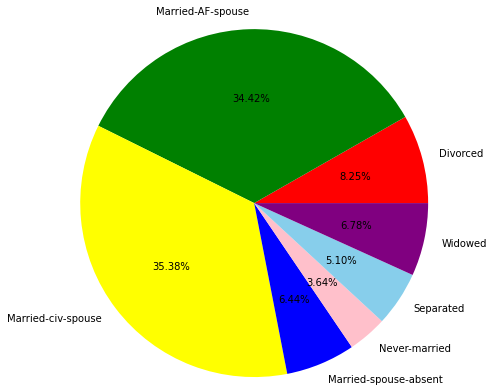

In [12]:
# probability of belonging to the group with the highest income
marital_income = dict(df.groupby('marital.status')['income'].mean())
label = list(marital_income.keys())
slices = list(marital_income.values())
color=['red','green','yellow','blue','pink','skyblue','purple']
plt.pie(slices,labels=label,colors=color,radius=2,autopct="%0.2f%%")
plt.show()

* Above pie chart shows marital statewise Probability of earning >50k

* Probabilities are what we would expect. Married people have more probability than the rest.

In [13]:
df['occupation'].value_counts() 

Prof-specialty       4140
Craft-repair         4099
Exec-managerial      4066
Adm-clerical         3770
Sales                3650
Other-service        3295
Machine-op-inspct    2002
?                    1843
Transport-moving     1597
Handlers-cleaners    1370
Farming-fishing       994
Tech-support          928
Protective-serv       649
Priv-house-serv       149
Armed-Forces            9
Name: occupation, dtype: int64

* As we see above there are 1843 missing values. It must be correlated with workclass

In [14]:
# Show null values in common
work_ocupation = df.loc[df['workclass'] == df['occupation'],'workclass']
work_ocupation.value_counts()

?    1836
Name: workclass, dtype: int64

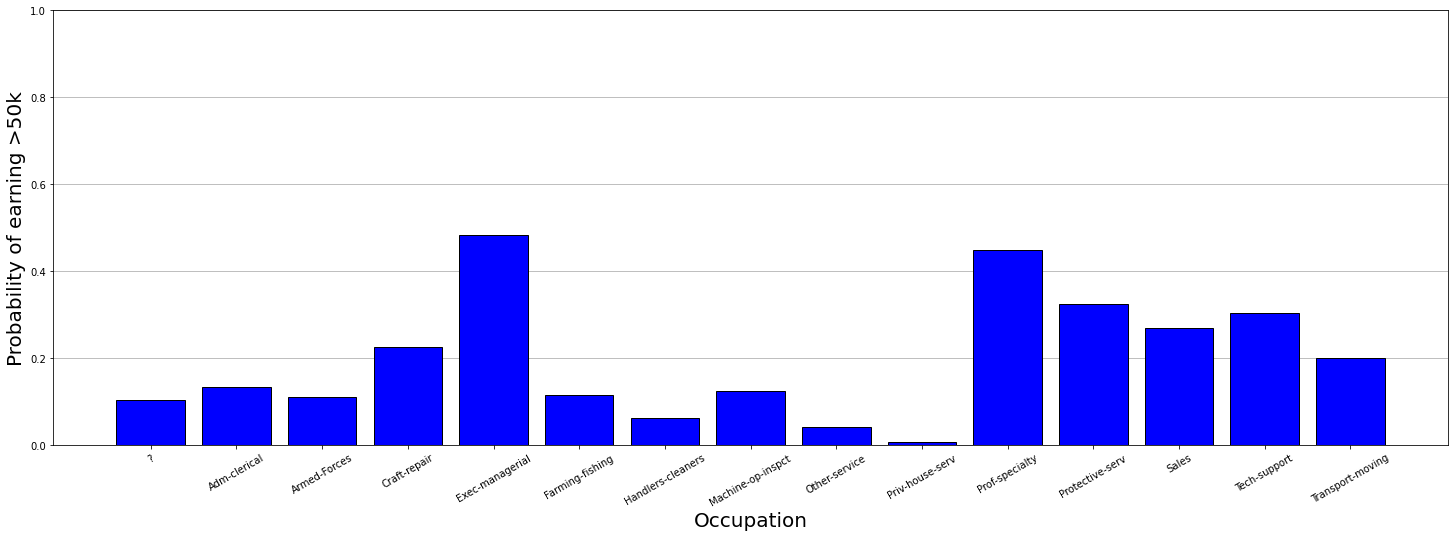

In [15]:
# probability of belonging to the group with the highest income
occupation_income = df.groupby('occupation')['income'].mean()

plt.figure(figsize=(25, 8))
plt.ylim(0,1)
plt.xticks(rotation=30) # rotate axis text
plt.bar(occupation_income.index.astype(str), occupation_income,
       color = 'blue', edgecolor='black' )
plt.ylabel('Probability of earning >50k', size=20)
plt.xlabel('Occupation', size=20)
plt.grid(axis='y')

In [16]:
df['relationship'].value_counts() 

Husband           13193
Not-in-family      8305
Own-child          5068
Unmarried          3446
Wife               1568
Other-relative      981
Name: relationship, dtype: int64

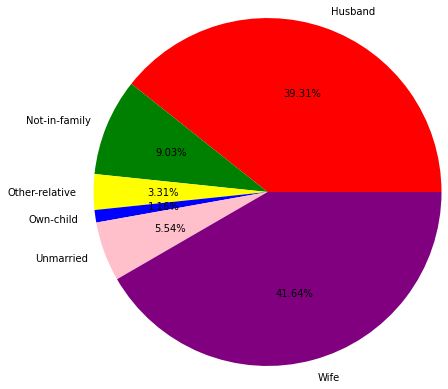

In [17]:
relationship_income = dict(df.groupby('relationship')['income'].mean())
label = list(relationship_income.keys())
slices = list(relationship_income.values())
color=['red','green','yellow','blue','pink','purple']
plt.pie(slices,labels=label,colors=color,radius=2,autopct="%0.2f%%")
plt.show()

* Above pie chart shows relationshipwise Probability of earning >50k
* As we see married people earn more than others

In [18]:
df['race'].value_counts()

White                 27816
Black                  3124
Asian-Pac-Islander     1039
Amer-Indian-Eskimo      311
Other                   271
Name: race, dtype: int64

*  There are no null values.

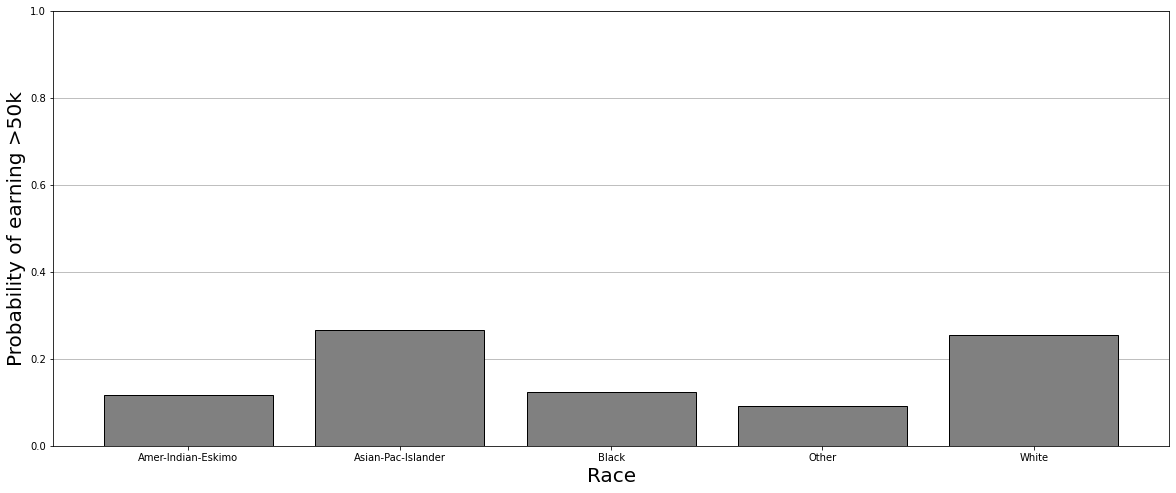

In [19]:
race_income = df.groupby('race')['income'].mean()

plt.figure(figsize=(20, 8))
plt.ylim(0,1)
plt.bar(race_income.index.astype(str), race_income,
       color = 'gray', edgecolor='black')
plt.ylabel('Probability of earning >50k', size=20)
plt.xlabel('Race', size=20)
plt.grid(axis='y')


* As we see Asian-Pac-Islander and White people have increased probability of earning more than 50k

In [20]:
df['sex'].value_counts()

Male      21790
Female    10771
Name: sex, dtype: int64

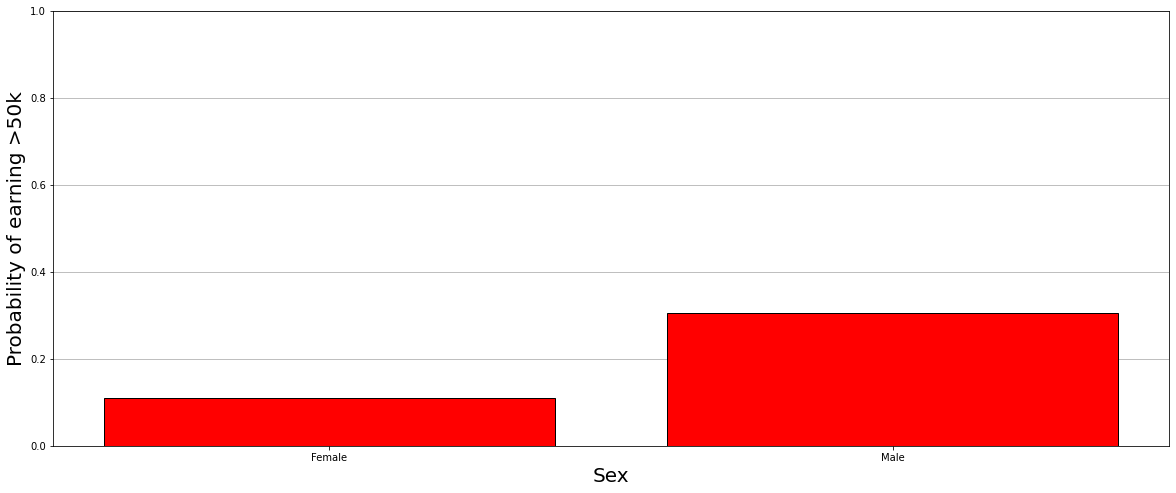

In [21]:
sex_income = df.groupby('sex')['income'].mean()

plt.figure(figsize=(20, 8))
plt.ylim(0,1)
plt.bar(sex_income.index.astype(str), sex_income,
       color = 'red', edgecolor='black')
plt.ylabel('Probability of earning >50k', size=20)
plt.xlabel('Sex', size=20)
plt.grid(axis='y')

* Males have higher probability of earning >50k than females.

In [22]:
df['native.country'].unique() 

array(['United-States', '?', 'Mexico', 'Greece', 'Vietnam', 'China',
       'Taiwan', 'India', 'Philippines', 'Trinadad&Tobago', 'Canada',
       'South', 'Holand-Netherlands', 'Puerto-Rico', 'Poland', 'Iran',
       'England', 'Germany', 'Italy', 'Japan', 'Hong', 'Honduras', 'Cuba',
       'Ireland', 'Cambodia', 'Peru', 'Nicaragua', 'Dominican-Republic',
       'Haiti', 'El-Salvador', 'Hungary', 'Columbia', 'Guatemala',
       'Jamaica', 'Ecuador', 'France', 'Yugoslavia', 'Scotland',
       'Portugal', 'Laos', 'Thailand', 'Outlying-US(Guam-USVI-etc)'],
      dtype=object)

* Here we can observe missing values 

* Below code displays the number of missing values in native.country

In [23]:
df.loc[df['native.country'] == '?', 'native.country'].count() 

583

In [24]:
# Show if missing values have something to do with occupation missing data
df.loc[df['native.country'] == 'occupation','occupation' ].count()

0

In [25]:
# Show if missing values have something to do with workclass missing data
df.loc[df['native.country'] == 'workclass','workclass' ].count()

0

<h1>Correlation between variables</h1>

<h2>Education</h2>

In [26]:
df['education'].unique()

array(['HS-grad', 'Some-college', '7th-8th', '10th', 'Doctorate',
       'Prof-school', 'Bachelors', 'Masters', '11th', 'Assoc-acdm',
       'Assoc-voc', '1st-4th', '5th-6th', '12th', '9th', 'Preschool'],
      dtype=object)

* No null values (i.e. ?) exists

In [27]:
df['education'].value_counts()

HS-grad         10501
Some-college     7291
Bachelors        5355
Masters          1723
Assoc-voc        1382
11th             1175
Assoc-acdm       1067
10th              933
7th-8th           646
Prof-school       576
9th               514
12th              433
Doctorate         413
5th-6th           333
1st-4th           168
Preschool          51
Name: education, dtype: int64

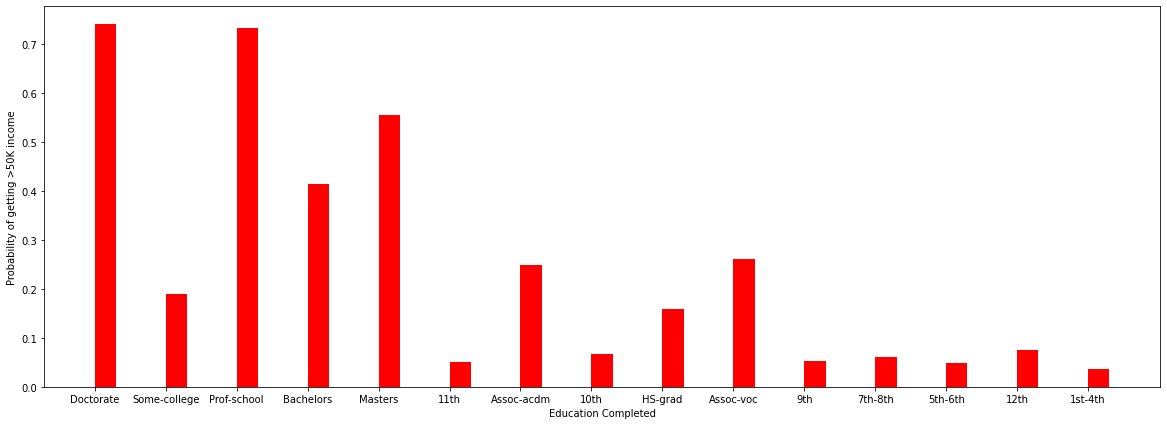

In [28]:
dt = {}
dttotl = dict(df['education'].value_counts()) # Gathers the frequencies of each element in education attribute.
prob = {}

# Counting number of people having income >50K.
for index, row in df.iterrows():
    
    if (row['income'] == 1):
        try:
            dt[row['education']] += 1
        except:
            dt[row['education']] = 1

for key in dt:
    prob[key] = dt[key] / dttotl[key] # Calculates the probability of getting >50K income for a particular education.

edu = list(prob.keys())
pb = list(prob.values())

plt.figure(figsize = (20, 7))
plt.bar(edu, pb, color = 'Red', align = 'edge', width = 0.3)
plt.xlabel("Education Completed")
plt.ylabel("Probability of getting >50K income")
plt.show()

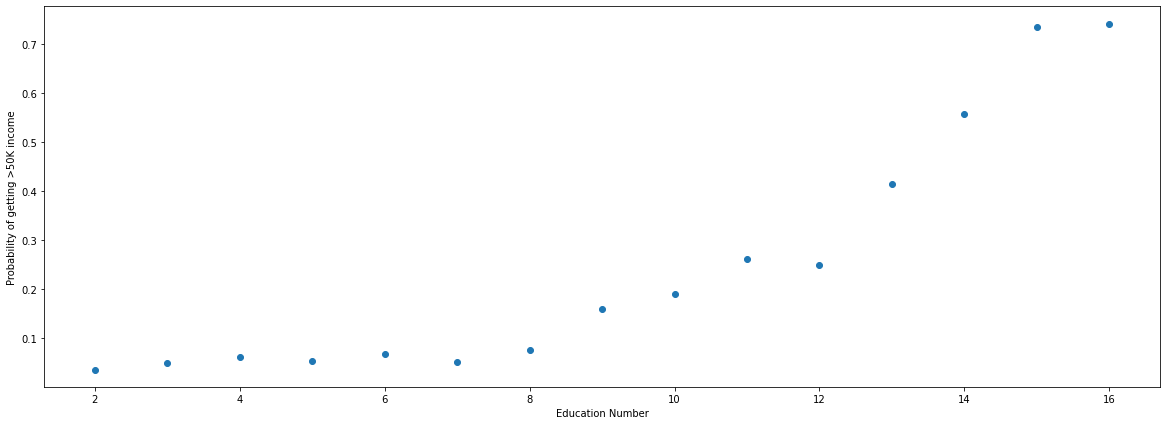

In [29]:
dt = {}
dttotl = dict(df['education.num'].value_counts())
prob = {}

for index, row in df.iterrows():
    
    if (row['income'] == 1):
        try:
            dt[row['education.num']] += 1
        except:
            dt[row['education.num']] = 1

for key in dt:
    prob[key] = dt[key] / dttotl[key]

edulvl = list(prob.keys())
pb = list(prob.values())

plt.figure(figsize = (20, 7))
plt.scatter(edulvl, pb)
plt.xlabel("Education Number")
plt.ylabel("Probability of getting >50K income")
plt.show()

* Above scatter plot shows the correlation between income (here scale of income is probability form) and education(here education is represented by education number)

<h2>Age</h2>

In [30]:
df['age'].unique()

array([90, 82, 66, 54, 41, 34, 38, 74, 68, 45, 52, 32, 51, 46, 57, 22, 37,
       29, 61, 21, 33, 49, 23, 59, 60, 63, 53, 44, 43, 71, 48, 73, 67, 40,
       50, 42, 39, 55, 47, 31, 58, 62, 36, 72, 78, 83, 26, 70, 27, 35, 81,
       65, 25, 28, 56, 69, 20, 30, 24, 64, 75, 19, 77, 80, 18, 17, 76, 79,
       88, 84, 85, 86, 87], dtype=int64)

In [31]:
df['age'].value_counts()

36    898
31    888
34    886
23    877
35    876
     ... 
83      6
85      3
88      3
87      1
86      1
Name: age, Length: 73, dtype: int64

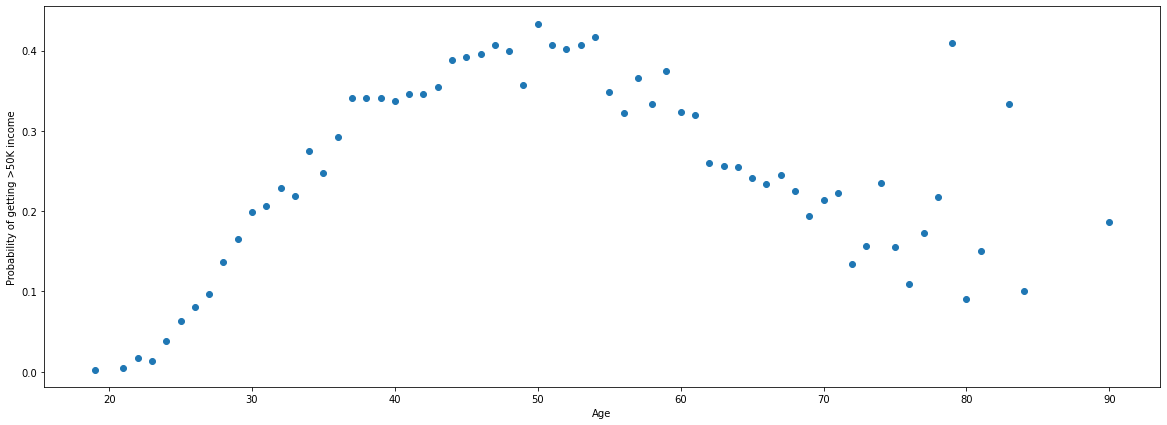

In [32]:
dt = {}
dttotl = dict(df['age'].value_counts())
prob = {}

for index, row in df.iterrows():
    
    if (row['income'] == 1):
        try:
            dt[row['age']] += 1
        except:
            dt[row['age']] = 1

for key in dt:
    prob[key] = dt[key] / dttotl[key]

age = list(prob.keys())
pb = list(prob.values())

plt.figure(figsize = (20, 7))
plt.scatter(age, pb)
plt.xlabel("Age")
plt.ylabel("Probability of getting >50K income")
plt.show()

* Above scatter plot shows the correlation between income (here scale of income is probability form) and age of the person
* As we can observe from the graph 45-55 age people have more income 

<h2>Working Hours Per Week</h2>

In [33]:
df['hours.per.week'].unique()

array([40, 18, 45, 20, 60, 35, 55, 76, 50, 42, 25, 32, 90, 48, 15, 70, 52,
       72, 39,  6, 65, 12, 80, 67, 99, 30, 75, 26, 36, 10, 84, 38, 62, 44,
        8, 28, 59,  5, 24, 57, 34, 37, 46, 56, 41, 98, 43, 63,  1, 47, 68,
       54,  2, 16,  9,  3,  4, 33, 23, 22, 64, 51, 19, 58, 53, 96, 66, 21,
        7, 13, 27, 11, 14, 77, 31, 78, 49, 17, 85, 87, 88, 73, 89, 97, 94,
       29, 82, 86, 91, 81, 92, 61, 74, 95], dtype=int64)

In [34]:
df['hours.per.week'].value_counts()

40    15217
50     2819
45     1824
60     1475
35     1297
      ...  
92        1
94        1
87        1
74        1
82        1
Name: hours.per.week, Length: 94, dtype: int64

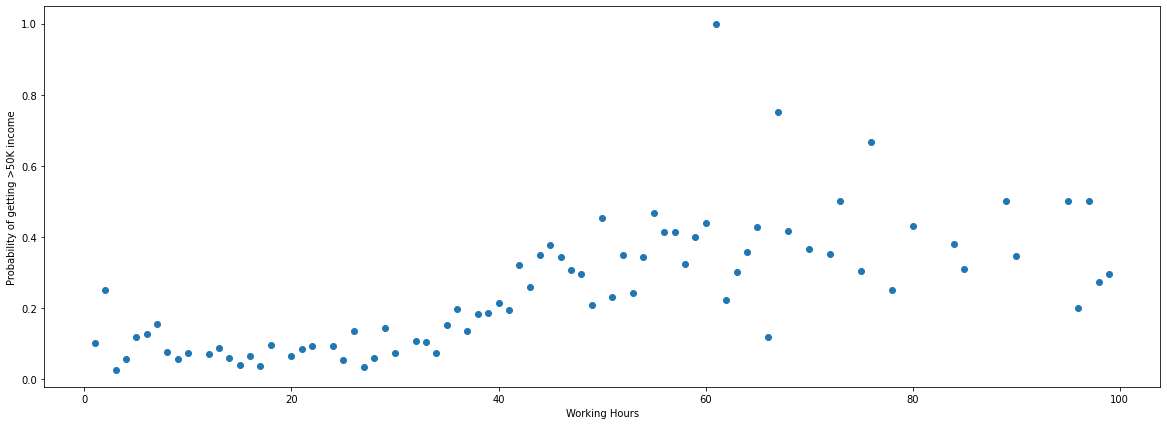

In [35]:
dt = {}
dttotl = dict(df['hours.per.week'].value_counts())
prob = {}

for index, row in df.iterrows():
    
    if (row['income'] == 1):
        try:
            dt[row['hours.per.week']] += 1
        except:
            dt[row['hours.per.week']] = 1

for key in dt:
    prob[key] = dt[key] / dttotl[key] # Calculates the probability of getting >50K income for a particular education.

hours = list(prob.keys())
pb = list(prob.values())

plt.figure(figsize = (20, 7))
plt.scatter(hours, pb)
plt.xlabel("Working Hours")
plt.ylabel("Probability of getting >50K income")
plt.show()

* Above scatter plot shows the correlation between income (here scale of income is probability form) and working hours per week of the person
* Here we can observe positive correlation i.e as working hours per week increases the probability of having salary >50k increases 

<h2>CORRELATION MATRIX</h2>

In [36]:
df.info() # Show continuous variables

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 3.7+ MB


<AxesSubplot:>

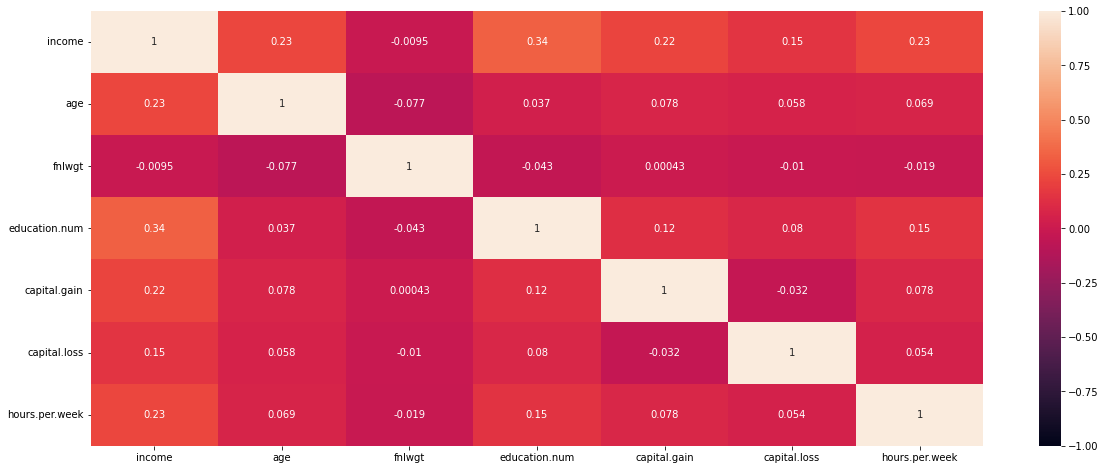

In [37]:
# Group all continuous variables 
df_continuous = df[['income','age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']]
# Correlation matrix
plt.figure(figsize=(20, 8))
sns.heatmap(data=df_continuous.corr(), annot=True, vmin=-1, vmax=1)

* Here from the above matrix we come to know which attributes are highly correlated
* fnlwgt has less correlation with income 
* education.num has highest correlation with income

In [38]:
df['age'].unique()

array([90, 82, 66, 54, 41, 34, 38, 74, 68, 45, 52, 32, 51, 46, 57, 22, 37,
       29, 61, 21, 33, 49, 23, 59, 60, 63, 53, 44, 43, 71, 48, 73, 67, 40,
       50, 42, 39, 55, 47, 31, 58, 62, 36, 72, 78, 83, 26, 70, 27, 35, 81,
       65, 25, 28, 56, 69, 20, 30, 24, 64, 75, 19, 77, 80, 18, 17, 76, 79,
       88, 84, 85, 86, 87], dtype=int64)

In [39]:
df.groupby('age')['age'].count()

age
17    395
18    550
19    712
20    753
21    720
     ... 
85      3
86      1
87      1
88      3
90     43
Name: age, Length: 73, dtype: int64

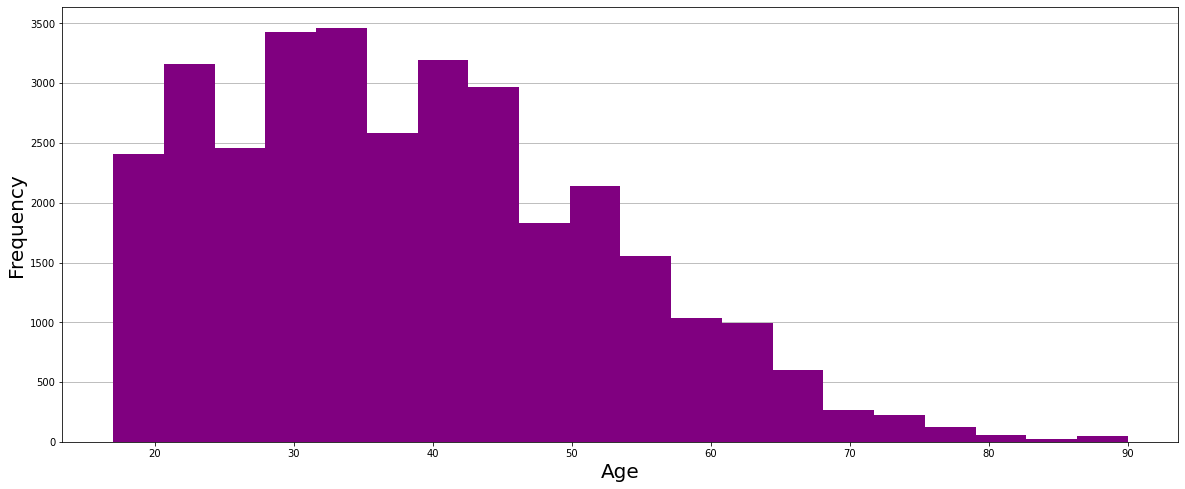

In [40]:
# plot histogram
plt.figure(figsize=(20, 8))
plt.hist(df['age'],density=False, bins=20, color = 'purple')
plt.ylabel('Frequency', size=20)
plt.xlabel('Age', size=20)
plt.grid(axis='y')

* The data is right skewed. More samples of younger people is present. This will be taken care by stratified sampling during model building

In [41]:
# Show average age by income
df.groupby("income")["age"].mean() 

income
0    36.783738
1    44.249841
Name: age, dtype: float64

* People with more than 50k are on average older.

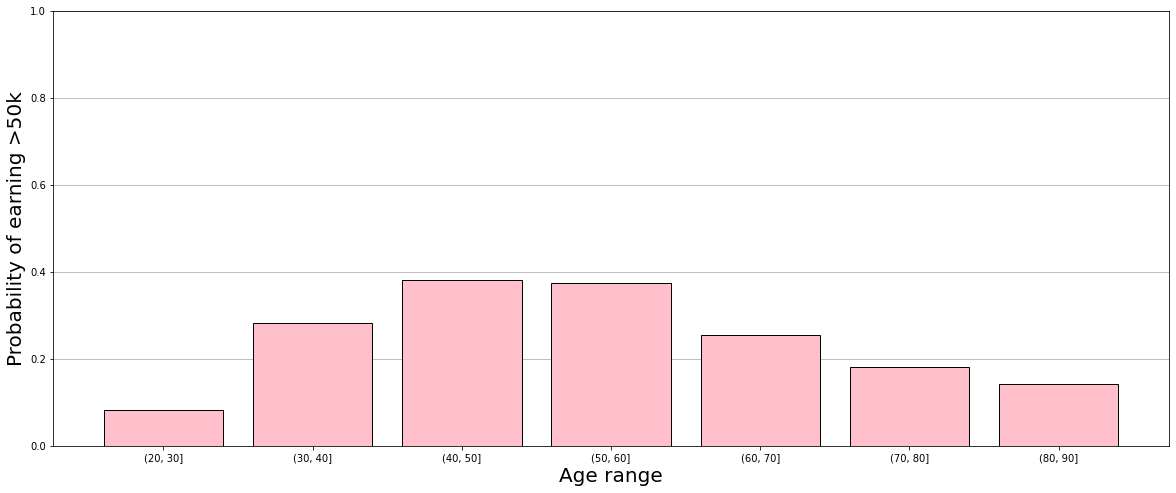

In [42]:
# divide age into groups
age_range = pd.cut(df['age'], bins = [20,30,40,50,60,70,80,90])

# show probability of belonging to the group with the highest income
age_income = df.groupby(age_range)['income'].mean()

# barplot showing probability of belonging to the group with the highest income per age range
plt.figure(figsize=(20, 8))
plt.ylim(0,1)
plt.bar(age_income.index.astype(str), age_income, color = 'pink',
       edgecolor='black')
plt.ylabel('Probability of earning >50k', size=20)
plt.xlabel('Age range', size=20)
plt.grid(axis='y')

* Results match with what we would expect(i.e people of age between 40-60 have more income)

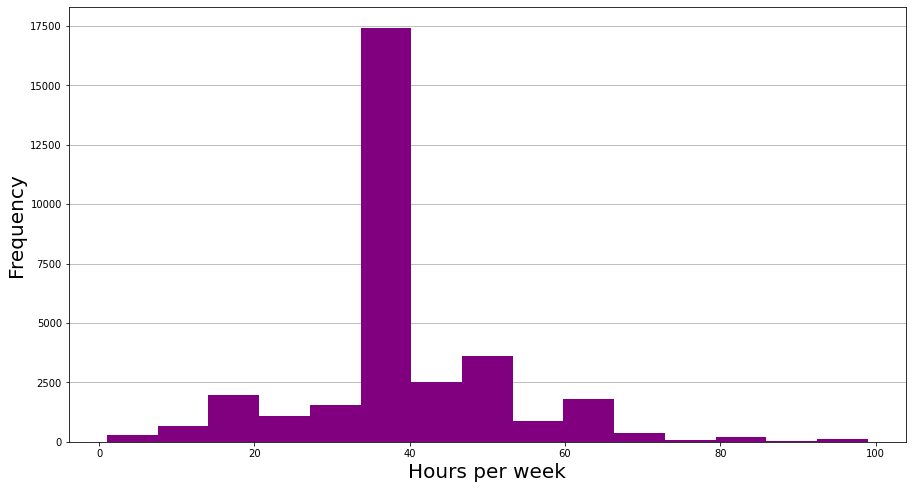

In [43]:
# plot histogram
plt.figure(figsize=(15, 8))
plt.hist(df['hours.per.week'],density=False, bins=15,  color = 'purple')
plt.ylabel('Frequency', size=20)
plt.xlabel('Hours per week', size=20)
plt.grid(axis='y')

* More people work between 30-50 hours a week

<h1>CLEANING THE DATA</h1>

<h2>Drop useless variables</h2>

* We have seen that fnlwgt variable has a really small correlation with the target variable so we can drop it. We can also drop education.num since not doing that it will result in a multicollinearity problem with education.

In [44]:
df = df.drop('fnlwgt', axis=1)
df = df.drop('education.num', axis=1)
df.shape

(32561, 13)

<h2> Deal with missing data </h2>

* As we have a lot of data and the missing values is just a small part of the dataset, we drop rows with missing values.

In [45]:
df = df.loc[ (df['workclass'] != '?') & (df['occupation'] != '?') & (df['native.country']!= '?')]
df.shape

(30162, 13)

<h2> Split data and get dummies</h2>


* First we will split the data into dependent and independent variables, and then we will split the dependent variables into continous variables and categorical variables.

In [46]:
X = df.drop('income', axis=1)
y = df['income']

In [47]:
X_continous  = X[['age', 'capital.gain', 'capital.loss', 'hours.per.week']]

X_categorical = X[['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race',
                   'sex', 'native.country']]

* Now we can get the dummies from the categorical variables and concatenate both continous and categorical datasets.

In [48]:
X_encoded = pd.get_dummies(X_categorical)
# Concatenate both continous and encoded sets:
X = pd.concat([X_continous, X_encoded],axis=1)
X

,age,capital.gain,capital.loss,hours.per.week,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,...,native.country_Portugal,native.country_Puerto-Rico,native.country_Scotland,native.country_South,native.country_Taiwan,native.country_Thailand,native.country_Trinadad&Tobago,native.country_United-States,native.country_Vietnam,native.country_Yugoslavia
1,82,0,4356,18,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,54,0,3900,40,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,41,0,3900,40,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,34,0,3770,45,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
6,38,0,3770,40,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,22,0,0,40,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
32557,27,0,0,38,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
32558,40,0,0,40,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
32559,58,0,0,40,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


<h1> Proposed models </h1>

* In this section we will develop the predictive models.

<h2>1.Gaussian Naive Bayes model</h2>

In [49]:
# Prepare the data. We only use continous independent variables 
X_train, X_test, y_train, y_test = train_test_split(X_continous, y, test_size= 1/3,
                                                    stratify=y, random_state=10)

# MODEL
gnb = GaussianNB()
gnb = gnb.fit(X_train, y_train)

# CROSS VALIDATION
cv = StratifiedKFold(n_splits=3)
val_cnb = cross_val_score(gnb, X_train, y_train, cv=cv).mean()
val_cnb # validation set score

0.7879947749403174

In [50]:
# PREDICTIONS
gnb_predictions = gnb.predict(X_test)
acc_gnb = accuracy_score(y_test,gnb_predictions)
acc_gnb # test set score

0.7917246866918639

<h2> 2.Random Forest model </h2>

In [51]:
# Prepare the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 1/3,
                                                    stratify=y, random_state=10)

In [52]:
# HYPERPARAMETERS OPTIMIZATION
param_grid = {
'max_depth' : [8,10,12,16,18,20],
'n_estimators': [50,100,200],
'max_samples': [1,0.8,0.6]
}

cv = StratifiedKFold(n_splits=3)

optimal_params = GridSearchCV(
    estimator = RandomForestClassifier(),
    param_grid = param_grid,
    scoring = 'accuracy',
    verbose = 2,
    cv = cv
)
 


In [53]:
# MODEL
Rforest = RandomForestClassifier(max_depth=16,max_samples=0.6, n_estimators=200)
Rforest = Rforest.fit(X_train, y_train)

# CROSS VALIDATION
cv = StratifiedKFold(n_splits=3)
val_Rforest = cross_val_score(Rforest, X_train, y_train, cv=cv).mean()
val_Rforest # validation score

0.8587127787102519

In [54]:
# PREDICTIONS
Rforest_predictions = Rforest.predict(X_test)
acc_Rforest = accuracy_score(y_test,Rforest_predictions)
acc_Rforest # test score

0.8568728864133678

<h2>3. XGBoost model</h2>

In [55]:
# Prepare the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 1/3,stratify=y, random_state=10)

In [56]:
# HYPERPARAMETER OPTIMIZATION

# ROUND 1

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.3, 0.1, 0.05],
    'gamma': [0, 1, 10],
    'reg_lambda': [0, 1, 10]
}


cv = StratifiedKFold(n_splits=3)

optimal_params = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic', #for binary classification
                                eval_metric="logloss",
                                use_label_encoder=False), #avoid warning (since we have done encoding)
    param_grid=param_grid,
    scoring='accuracy',
    verbose=2,
    cv = cv
)

 
# ROUND 2


param_grid = {
    'max_depth': [4, 5, 6],
    'learning_rate': [0.3, 0.5],
    'subsample': [1, 0.8, 0.6, 0.4],
    'gamma' : [10, 50, 100]
}



cv = StratifiedKFold(n_splits=3)

optimal_params = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic', #for binary classification
                                eval_metric="logloss",
                                learning_rate= 0.1,
                                reg_lambda=0,
                                use_label_encoder=False), #avoid warning (since we have done encoding)
    param_grid=param_grid,
    scoring='accuracy',
    verbose=2,
    cv = cv
)


In [57]:
# MODEL
xgbm = xgb.XGBClassifier(eval_metric="logloss",
                        learning_rate= 0.3,
                        reg_lambda=10,
                        use_label_encoder=False, # as we have done encoding
                        max_depth=5,
                        subsample=1)

xgbm = xgbm.fit(X_train, y_train)

# CROSS VALIDATION
cv = StratifiedKFold(n_splits=3)
val_xgbm = cross_val_score(xgbm, X_train, y_train, cv=cv).mean()
val_xgbm

0.8679132404907727

In [58]:
xgbm_predictions = xgbm.predict(X_test)
acc_xgbm = accuracy_score(y_test,xgbm_predictions)
acc_xgbm

0.8685100457529341

In [59]:
# Save predictions with probabilities in order to later make the ensembling
xgbm_predictions_prob = xgbm.predict_proba(X_test)
xgbm_predictions_prob = xgbm_predictions_prob[:,1]

<h2>4. Artificial Neural Networks</h2>

In [60]:
# Prepare the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 1/3, 
                                                    stratify=y, random_state=10)
# scale the data (mean=0, sd=1)
X_train = scale(X_train)
X_test = scale(X_test)

* Hyperparameters optimization

In [61]:
# ROUND 1

# first we need to define the model 
def ANN_1(neurons=10, hidden_layers=0, dropout_rate=0, learn_rate= 0.1):
    # model
    model = keras.Sequential()
    model.add(keras.layers.Dense(neurons, input_shape = (X_train.shape[1], ), activation='relu'))
    for i in range(hidden_layers):
        # Add one hidden layer
        model.add(keras.layers.Dense(neurons, activation='relu'))
        model.add(keras.layers.Dropout(dropout_rate))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    # Compile model
    optimizer = keras.optimizers.SGD(lr=learn_rate, momentum = 0)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# we will do the grid search with KerasClassifier
ann = KerasClassifier(build_fn=ANN_1, batch_size=30)


param_grid = {
    'neurons': [10, 30, 60, 100, 200],
    'hidden_layers': [0, 1, 2],
    'dropout_rate': [0, 0.1, 0.2, 0.4],
    'epochs': [8,15],
    'learn_rate': [0.1, 0.03]
}

cv = StratifiedKFold(n_splits=3)

optimal_params = GridSearchCV(estimator=ann, param_grid=param_grid, verbose=2, cv=cv)

 
# ROUND 2

def ANN_2(init_mode='uniform', activation='relu'):
    # model
    model = keras.Sequential()
    model.add(keras.layers.Dense(10,kernel_initializer=init_mode,
                                 input_shape = (X_train.shape[1], ), activation=activation))
    model.add(keras.layers.Dense(10, kernel_initializer=init_mode,activation=activation))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(1,kernel_initializer=init_mode, activation='sigmoid'))
    # Compile model
    optimizer = keras.optimizers.SGD(lr=0.1, momentum = 0)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


ann = KerasClassifier(build_fn=ANN_2, epochs= 15,  batch_size=30)


param_grid = {
    'init_mode': ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal',
                  'glorot_uniform', 'he_normal', 'he_uniform'],
    'activation': ['softmax','relu', 'tanh', 'sigmoid']
}


cv = StratifiedKFold(n_splits=3)


optimal_params = GridSearchCV(estimator=ann, param_grid=param_grid, verbose=2, cv=cv)

 

In [62]:
def ANN_():
    model = keras.Sequential()
    model.add(keras.layers.Dense(10,kernel_initializer='uniform',
                                 input_shape = (X_train.shape[1], ), activation='relu'))
    model.add(keras.layers.Dense(10, kernel_initializer='uniform',activation='relu'))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(1,kernel_initializer='uniform', activation='sigmoid'))
    # Compile model
    optimizer = keras.optimizers.SGD(lr=0.1, momentum = 0)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# we define a learning rate schedule in order to decrease the learning rate
# as we epoch increases.

def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  if epoch < 15:
	  return 0.05
  else:
      return 0.01


# Early stopping: stop the learning when it has 3 consecutive epoch without improvement
callback2 = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
# Learning rate schedule
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

ann = KerasClassifier(build_fn=ANN_, epochs= 15,  batch_size=30, verbose=0)


# CROSS VALIDATION
cv = StratifiedKFold(n_splits=3)
val_ann= cross_val_score(ann, X_train, y_train,
                         cv=cv, fit_params={'callbacks': [callback,callback2]}).mean()
val_ann # validation score

C:\Users\DELL\anaconda3\lib\site-packages\scikeras\wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"
C:\Users\DELL\anaconda3\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
C:\Users\DELL\anaconda3\lib\site-packages\scikeras\wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"
C:\Users\DELL\anaconda3\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
C:\Users\DELL\anaconda3\lib\site-package

0.8460313924147713

In [63]:
n_members = 10
ann_dict = {} # dictionary where we will store the predictions

for i in range(n_members):
    ann = ANN_()
    ann.fit(X_train, y_train, epochs=15, batch_size=30, 
            verbose=0, callbacks=[callback, callback2])
    ann_predictions = ann.predict(X_test)
    ann_predictions = ann_predictions.reshape(ann_predictions.shape[0], )
    ann_dict["ann%s" %i] = ann_predictions

# create a pandas DataFrame from the dictionary
ann_dataframe = pd.DataFrame.from_dict(ann_dict)

ann_mean_prob = ann_dataframe.mean(axis=1) #averaging all the ANN predictions for each row
ann_mean = np.where(ann_mean_prob > 0.5, 1, 0) # transforem probabilities to a binary variable
acc_ann = accuracy_score(y_test, ann_mean)
acc_ann # test score

C:\Users\DELL\anaconda3\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


0.8548836284066044

In [64]:
np.array([val_cnb, val_Rforest, val_xgbm, val_ann])

array([0.78799477, 0.85871278, 0.86791324, 0.84603139])

<h2>5. ANN-XGBoost Ensemble<h2>

In [65]:
best_predictions = pd.DataFrame(data= {'ann':ann_mean_prob, 
                                       'xgb':xgbm_predictions_prob})

# We give a higher weight to XGBoost
ensembling = best_predictions['ann']* 0.4 + best_predictions['xgb']*0.6

# Probabilities to binary
ensembling_binary = np.where(ensembling > 0.5, 1, 0)
acc_ensembling = accuracy_score(y_test, ensembling_binary)
acc_ensembling # test score

0.8703998408593595

In [66]:
results = {'Gaussian naive base':acc_gnb,
           'Random Forest': acc_Rforest,
           'XGBoost':acc_xgbm ,
           'Artificial Neural Networks':acc_ann ,
           'XGBoost-ANN Ensembling': acc_ensembling,         
          }

results_dataframe = pd.DataFrame.from_dict(results, orient='index', 
                                           columns=['Accuracy'])
results_dataframe

,Accuracy
Gaussian naive base,0.791725
Random Forest,0.856873
XGBoost,0.868510
Artificial Neural Networks,0.854884
XGBoost-ANN Ensembling,0.870400
